#**IMAGE CAPTIONING USING SPATIAL ATTENTION**

This is the implementation of the Spatial Attention Model explained in the paper "Knowing When to Look: Adaptive Attention via
A Visual Sentinel for Image Captioning" ( https://arxiv.org/abs/1612.01887 )

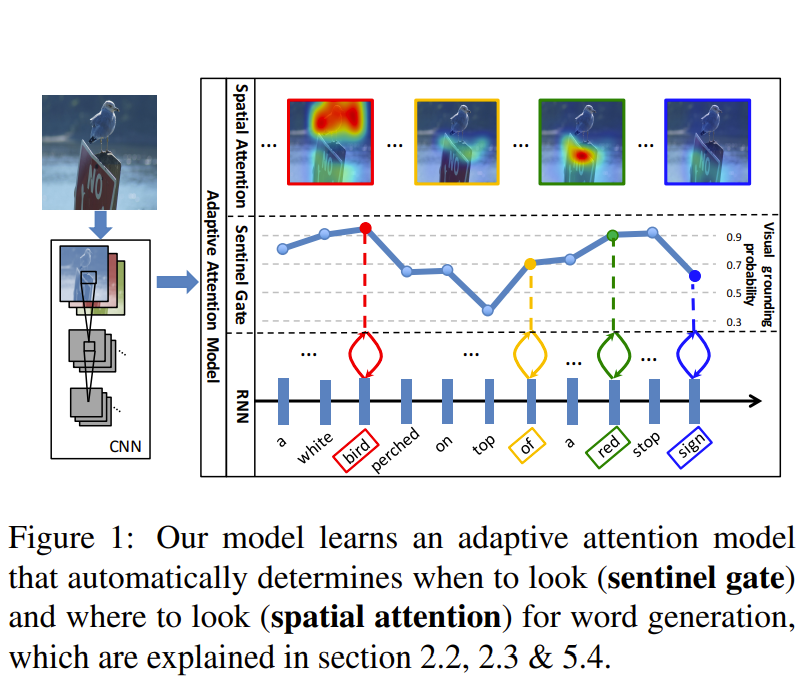

#Creating the Vocabulary

In [1]:
import spacy
spacy_eng = spacy.load("en")

class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name): #creating various dictionaries
        self.name = name
        self.word2index = {'PAD': 0, 'SOS': 1, 'EOS': 2} #maps words to indexes
        self.word2count = {} #counts the number of times a particular word occurs
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"} #maps indexes to words
        self.num_words = 3 #total number of unique words/tokens (including EOS, SOS and PAD)
        self.num_sentences = 0 
        self.longest_sentence = 0
    


    def add_word(self, word): #adding words/tokens to the several dictionaries
        if word not in self.word2index:
            # First entry of word into vocabulary (if the word doesnt already exist in word2index and index2word; add it to the same)
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # If Word already exists in word2index and index2word; increase word count
            self.word2count[word] += 1

    def tokenizer(self,text): #Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens. The tokens could be words, numbers or punctuation marks.
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def add_sentence(self, sentence):
        sentence_len = 0
        #for word in sentence.split(' '):
        for word in self.tokenizer(sentence):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [2]:
!pip install kaggle
%env KAGGLE_USERNAME= jeshlindonnamm20b029
%env KAGGLE_KEY= 7edd472059b07f736128c0fa2369e7da


!kaggle datasets download -d hsankesara/flickr-image-dataset


env: KAGGLE_USERNAME=jeshlindonnamm20b029
env: KAGGLE_KEY=7edd472059b07f736128c0fa2369e7da
100% 8.16G/8.16G [03:16<00:00, 24.7MB/s]
100% 8.16G/8.16G [03:17<00:00, 44.5MB/s]


In [3]:
!unzip "/content/flickr-image-dataset.zip"      

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [4]:
import pandas as pd
import re #Regular expression or RegEx in Python is denoted as RE are imported through re module. Python supports regular expression through libraries. RegEx in Python supports various things like Modifiers, Identifiers, and White space characters.

df = pd.read_csv('../content/flickr30k_images/results.csv',delimiter='|')

df

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [5]:
df[' comment'] = df[' comment'].str.lower() #reduces all letters in the comments to lower case
df[' comment'].replace( { r'[^a-zA-Z0-9, ]' : '' }, inplace= True, regex = True) #anything other than (a-z)(A-Z)(0-9)(comma)(space) will be removed
                                                                                 # ^ means "not" in regex
# fixing an issue/error in the dataset.
df[' comment_number'][19999] = 4
df[' comment'][19999] = ' a dog runs across the grass '

# creating the vocabulary 
vocab = Vocabulary('test')

# adding words to the vocabulary 
for sentence in df[' comment']:
    vocab.add_sentence(sentence) 

# converting the captions to tokens 
sent_idxs = [] # sent_idxs is a list that will contain the indexes representing each word/token of the sentance
captions = [] # captions is a list that will contain the sent_idxs lists of all sentances
for idx, sentence in enumerate (df[' comment']): #Enumerate returns the index(idx) and the value inside that index(sentance)
    i = 0                                        # we use idx to just keep track of the iterations
    '''for word in sentence.split(' '):
        if i==0:
            sent_idxs.append(1)
        index = vocab.to_index(word)    
        if index != 3:    
            sent_idxs.append(index)
        elif index == 3 and i !=0:
            sent_idxs.append(2)
        i+=1'''
    #for word in sentence.split(' '):
    for word in vocab.tokenizer(sentence):
        sent_idxs.append(vocab.to_index(word))
        i+=1
    while i < ((vocab.longest_sentence) + 1): #padding the sentances until length of the sentace becomes equal to the length of the longest sentance
        sent_idxs.append(0)
        i+=1
    captions.append(sent_idxs)
    sent_idxs = []

# converting list of word tokens to numpy array
import numpy as np
captions = np.array(captions)
captions.shape

(158915, 83)

In [6]:
captions

array([[ 3,  4,  5, ...,  0,  0,  0],
       [ 3,  4,  5, ...,  0,  0,  0],
       [ 3,  4, 28, ...,  0,  0,  0],
       ...,
       [ 3, 32, 33, ...,  0,  0,  0],
       [ 3, 32, 33, ...,  0,  0,  0],
       [ 3, 32, 33, ...,  0,  0,  0]])

In [7]:
# adding start and end tokens
for i in range(len(captions)):
    for j in range(1,84):
        if captions[i,j] == 0:
            if captions[i,j-1] == 3: #so in the the vocabulary the index 3 refers to a space. and in the captions given in the dataset, most sentences end with a space. So we check if the sentance ends with a space just replace the space with EOS
                captions[i,j-1] = 2
            else:                    #If there is no space at the end of the sentance, we replace the first PAD with EOS
                captions[i,j] = 2
            break  

captions[:,0] = 1 #adding start token

#Loading the embeddings
GloVe embeddings are a word to vector technique that leverages both global and local statistics of a corpus in order to come up with a principled loss function which uses both these.

In [8]:
!kaggle datasets download -d anindya2906/glove6b

 99% 838M/844M [00:34<00:00, 16.7MB/s]
100% 844M/844M [00:34<00:00, 25.7MB/s]


In [9]:
!unzip "/content/glove6b.zip"   

Archive:  /content/glove6b.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [10]:
import numpy as np 
vocabs = vocab.word2index.keys()

def load_embeds(root_dir):
    embeddings_index = dict()
    f = open(root_dir)

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    return embeddings_index
    
embeddings_index = load_embeds('../content/glove.6B.300d.txt')

In [11]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [12]:
import torch


def load_embed_weights(embeddings_index, embed_dim, vocab, vocab_size):
    matrix_len = vocab_size
    weights_matrix = np.zeros((matrix_len, embed_dim))
    words_found = 0

    for i, word in enumerate(vocab):
        try: 
            weights_matrix[i] = embeddings_index[word]
            words_found += 1
        #but if the embedding for that word is not found in the glove embeddings, then:    
        except KeyError: 
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim, ))

    weights_matrix = torch.tensor(weights_matrix)
    return weights_matrix


weights_matrix = load_embed_weights(embeddings_index, 300, vocabs, vocab.num_words)
weights_matrix.shape

torch.Size([19998, 300])

#Some helper functions which we will be using later

In [13]:
def output_to_caption(outputs, index):
    preds = outputs[index]
    preds = torch.argmax(preds, dim = 1)
    preds = preds.cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break    
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_caption(preds, index):
    preds = preds[index].cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_image(img_list, index):
    img = img_list[index].permute(1,2,0)
    plt.figure()
    plt.imshow(img.cpu())

#Creating the dataloader

an adult wearing a gray shirt with red sleeves sleeping on a couch 

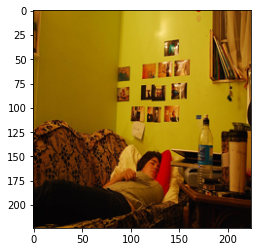

In [14]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Data(Dataset):

    def __init__(self, root_dir, captions):
        
        self.root_dir = root_dir
        self.df = pd.read_csv(root_dir+'results.csv', delimiter = '|')
        self.captions_tensor = torch.tensor(captions)
        self.captions = captions
        self.imgloc = self.df['image_name']
        self.img_list = glob(root_dir+'flickr30k_images/*')
    
    def __getcaption__(self,index):
        return self.captions[5*index] # 5*index because, Each image has 5 captions which is stored in "captions", but we are using only one caption for each image 
    
    def __getitem__(self,index):
        
        img = self.root_dir+'flickr30k_images/'+ self.imgloc[5*index]
        caption = self.captions[5*index]
        img_tensor = (torch.tensor(np.array(Image.open(img).resize((224,224)))).permute(2,0,1) )/255
        return img_tensor, caption
    
    def __len__(self):
        return (len(self.img_list)-2)


data = Data('../content/flickr30k_images/flickr30k_images/', captions)
img, caption_tensor = data.__getitem__(99)
caption = data.__getcaption__(99)
plt.imshow(img.permute(1,2,0))
for idx in caption:
    if idx == 1:
        continue
    if idx !=2:
        print(vocab.to_word(idx), end =" ") #Normally when you do print, it prints and goes to next line. Basically end = \n by default. But to prevent this, we put end= space i.e. " "
    else:
        break

In [15]:
batch_size = 32
data_len = len(data)

trainset, valset = random_split(data, [int(0.8*data_len), (data_len - int(0.8*data_len))])

trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle = True)
valloader = DataLoader(dataset=valset, batch_size=batch_size, shuffle = True)



men wearing black shirts are breakdancing with onlookers 

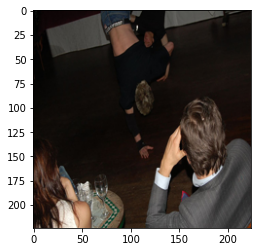

In [16]:
for img_list, caption in trainloader:
    plt.imshow(img_list[4].permute(1,2,0)) #torch.permute() rearranges the original tensor according to the desired ordering and returns a new multidimensional rotated tensor. The size of the returned tensor remains the same as that of the original.
    tensor_to_caption(caption,4)
    break

# MODEL

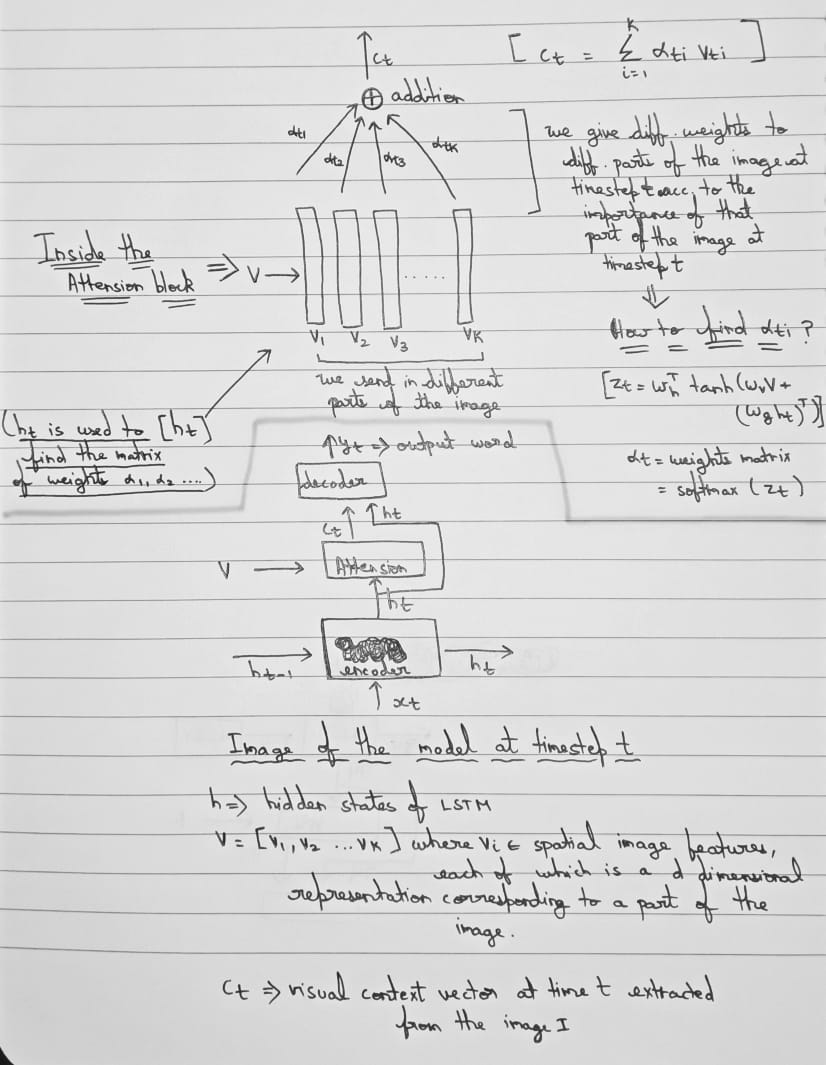

#Encoder

In [17]:
import torchvision
import torch.nn as  nn

model = torchvision.models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model = model.features[:30]
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# Spational Attention (soft attension)

In [18]:
class attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, features, hidden_state):
        # features = [32,196,512], hidden_state = [32,512]
        hidden_state = hidden_state.unsqueeze(1)       #[32,1,512] 
        # Unsqueeze returns a new tensor with a dimension of size one inserted at the specified position. I.E torch.unsqueeze adds an additional dimension to the tensor. So let's say you have a tensor of shape (3), if you add a dimension at the [0] position, it will be of shape (1,3), which means 1 row and 3 columns as a dimension of value 1 has been added at position[0].
        #Now, to concatinate features and hidden_state, they need to have the same shape. So, we modify the shape of hidden_state
        ones = torch.ones(features.shape[1],1)  #[196,1]
        ones = ones.to(device)      

        hidden_state = ones @ hidden_state         #[32,196,512]       # @ symbol is used for matrix multiplication

        combine = torch.cat((features, hidden_state), dim = 2)   #[32,196,1024] by concatinating features and hidden_state to get z (as shown in the model archietecture)
        combine = combine.to(device) #moving it to the device we are using

        attn_weights = []

        for image in combine:
            #image = 196,1024
            out = self.relu(self.fc(image))  #[196,1]         
            out = out.squeeze(1)              #[196]
            attn_weights.append(out)

        # attn_weights = [32,196]
        attn_weights = torch.stack(attn_weights)    
        attn_weights = self.softmax(attn_weights)
        attn_weights = attn_weights.unsqueeze(1)  #[32,1,196]

        context = attn_weights @ features         #[32,1,512]      

        return context.squeeze(1)                 #[32,512]

#Decoder

In [19]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, device, attn, num_layers=1):
        super(Decoder, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size = embed_size + hidden_size, hidden_size=hidden_size)
    
        # output fully connected layer
        self.fc_out = nn.Linear(in_features = self.hidden_size*2, out_features = self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        self.embed.weight.requires_grad = False
        self.embed.load_state_dict({'weight': weights_matrix})
         
    def forward(self, features, captions):


        # features = [32,196,512], captions = [32,num_words]
        
        # batch size
        batch_size = features.size(0)    # 32
        
        # init the hidden and cell states to zeros
        
        #hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)    #[32,512]
        #cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)      #[32,512]
        
        hidden_state = torch.mean(features, dim = 1)    #[32,512]
        cell_state = torch.mean(features, dim = 1)      #[32,512]
        
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device) #captions.size(1) is the number of words 
        # outputs = [32,num_words,vocab_size]
        
        # embed the captions
        captions_embed = self.embed(captions)    #[32,num_words,300]
        
        # pass the caption word by word
        for t in range(captions.size(1)):

            # getting the features of the image to be focussed on  
            context = attn(features, hidden_state)  #[32,512]

            # concatnating it with the input word
            inputs = torch.cat((context, captions_embed[:, t, :]), dim = 1) # [32,812] 
            
            #passing the combination through lstm
            hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
            
            out = torch.cat((context, hidden_state), dim = 1)
            # output of the attention mechanism
            out = self.fc_out(out)
            
            # build the output tensor
            outputs[:, t, :] = out      
    
        return F.log_softmax(outputs, dim = 2)
vocab_size = vocab.num_words
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
attn = attention(512)
attn = attn.to(device)
decoder = Decoder(300,512, vocab_size,weights_matrix, device, attn)

#Training function

In [20]:


def train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device):
    best_loss = 100
    train_loss = []
    
    for idx, (img_list, caption) in enumerate (trainloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]    # skips SOS
        caption_train = caption[:,:-1]    # skips EOS
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features.permute(0,2,3,1)    # [32,49,49,512]
        features = features.view(-1, 196, 512) # [32,196,512]
        outputs = decoder(features, caption_train)
        #optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        loss = criterion(outputs.view(-1, vocab_size), caption_target.contiguous().view(-1))
        
        train_loss.append(loss.item())
        
        loss.backward()
        #optimizer_encoder.step()
        optimizer_decoder.step()
      
        
        
    print('\ntrain loss : {}\n'.format(np.mean(train_loss)))

    if np.mean(train_loss) < best_loss:
        best_loss = np.mean(train_loss)
        torch.save(decoder.state_dict(), 'weights_decoder.pth') #Cuz colab doesnt allow us to train for more than a certain period of time, we record the weights we get while training into a file. And when we train this model the next time, we can initialize the model using these saved weights and further train it for better results.

    print('\npredicted caption:')

    output_to_caption(outputs, 1)

    print("\n\nactual caption:")

    tensor_to_caption(caption, 1)
    
    print()

#Training

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss(ignore_index = 0 )
criterion.to(device)
encoder = model
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr = 1e-2)
#optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr = 1e-2)
encoder.to(device)
decoder.to(device)
epochs = 10

for epoch in range(epochs):
    train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device)
    
print("OVERALL TRAINING COMPLETE")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



train loss : 4.849806734301009


predicted caption:
a man player in in a and a man in the air with the bike 

actual caption:
a soccer player dressed in red takes a leap in the air as his teammate looks on 

train loss : 4.180569644844007


predicted caption:
a subject girls in a black shirt and a on a woman 

actual caption:
the young toddler in the striped shirt eats grapes and a banana as an afternoon snack at his grandmas 

train loss : 3.9663668539539074


predicted caption:
a men dogs running through the water 

actual caption:
two black dogs run through the snow with a red toy in one dog s mouth 

train loss : 3.770104033092283


predicted caption:
a men men are sitting to move of in at 

actual caption:
two asian students are trying to piece something back together 

train loss : 3.624886299229268


predicted caption:
a people boys are in a and on front of a unfinished s a other man a background of a cup cup 

actual caption:
several young children dressed in yellow stand in f

#Checking the captions for random pictures in the valset

In [25]:
decoder.load_state_dict(torch.load('./weights_decoder.pth'))
for idx, (img_list, caption) in enumerate (valloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]
        caption_train = caption[:,:-1]
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features.permute(0,2,3,1)    # [32,49,49,512]
        features = features.view(-1, 196, 512) # [32,196,512]
        outputs = decoder(features, caption_train)
        break


predicted caption:
a man in a dark and her hair and a headband and on white couch 

actual caption:
a woman with a flower in her hair and white gloves balances a glass bowl with water on her head 


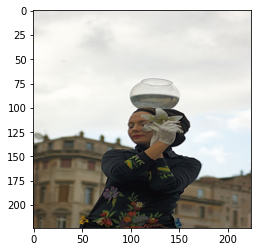

In [24]:
print('\npredicted caption:')
output_to_caption(outputs, 28)
print("\n\nactual caption:")
tensor_to_caption(caption, 28)
print()
tensor_to_image(img_list, 28)


predicted caption:
a women retrievers dogs and himself hurdle and by himself raging in a red shirt 

actual caption:
two golden brown horses pull a sleigh driven by a woman in a blue coat 


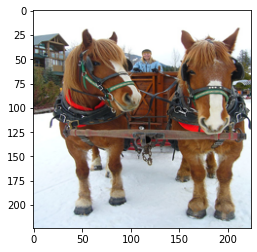

In [29]:
print('\npredicted caption:')
output_to_caption(outputs, 17)
print("\n\nactual caption:")
tensor_to_caption(caption, 17)
print()
tensor_to_image(img_list, 17)